We will use pre-trained YAMNet model

# Step 1: Load Model

In [18]:
import sys
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(PROJECT_ROOT)

In [9]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
from utils.embedding_extraction import extract_embedding
from config.constants import PROCESSED_AUDIO_DATA_DIR, CLEANED_AUDIO_DATA_DIR
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='tensorflow_hub')

print("YAMNet loaded successfully.")

C:\Users\Hakim\miniconda3\envs\tf_gpu\lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


YAMNet loaded successfully.


# Optional:
Take some samples from the data set to manually test the model after training

In [1]:
!python ../../utils/extract_manual_test_data.py

Traceback (most recent call last):
  File "C:\Users\Hakim\Documents\ENSET\IA_Avance\musical-instrument-classifier\utils\extract_manual_test_data.py", line 2, in <module>
    from config.constants import PROCESSED_AUDIO_DATA_DIR
ModuleNotFoundError: No module named 'config'


# Step 2: Prepare Data Set: Feature Extraction

In [10]:
# Assuming your CSV has columns: 'filename' and 'label'
csv_path = PROCESSED_AUDIO_DATA_DIR / "remaining.csv"
audio_folder = CLEANED_AUDIO_DATA_DIR

df = pd.read_csv(csv_path)

X = []
y = []

print("Extracting features (this may take a while)...")

for index, row in tqdm(df.iterrows()):
    file_path = audio_folder / row['filename']

    # Get the embedding
    emb = extract_embedding(file_path)

    if emb is not None:
        X.append(emb)
        y.append(row['label'])

X = np.array(X)
y = np.array(y)

print(f"Processed {len(X)} files.")
print(f"Feature shape: {X.shape}") # Should be (Number_of_files, 1024)

Extracting features (this may take a while)...


305957it [40:04, 127.22it/s]


Processed 305957 files.
Feature shape: (305957, 1024)


# Step 3: Encode Labels: Split Data

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
# Convert string labels (e.g., "Guitar", "Piano") to integers (0, 1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)

# Split Data (80% Train, 10% Validation, 10% Test)
# Split 80% 20%
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
# Split the 20% into 10% 10%
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scale Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# 4. Convert targets to One-Hot Encoding
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

# # Convert to TensorFlow tensors
# y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
# y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

print(f"Train shape: {X_train.shape}")
print(f"Val shape:   {X_val.shape}")
print(f"Test shape:  {X_test.shape}")

Train shape: (244765, 1024)
Val shape:   (30596, 1024)
Test shape:  (30596, 1024)


# Step 4: Build Model

In [13]:
model = models.Sequential([
    layers.Input(shape=(1024,)),         # Input is the 1024 vector from YAMNet

    # Hidden Layer 1
    layers.Dense(1024),
    layers.BatchNormalization(),   # Stabilizes learning
    layers.Activation('relu'),
    layers.Dropout(0.3),           # Prevents overfitting

    # Hidden Layer 2
    layers.Dense(512),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    # Hidden Layer 3
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    # --- Output Layer ---
    layers.Dense(num_classes, activation='softmax')
])

# Compile and Train

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [15]:
# 1. Compile with Label Smoothing
# Helps the model generalize better on large datasets
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

# 2. Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,               # Wait a bit longer since we have a scheduler
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,               # Reduce LR to 20% of previous value
    patience=3,               # If no improvement for 3 epochs
    min_lr=1e-6,
    verbose=1
)

# 3. Train
history = model.fit(
    X_train, y_train_cat,
    epochs=100,               # You can set this high, EarlyStopping will handle it
    batch_size=256,           # Increased for faster training on large data
    validation_data=(X_val, y_val_cat),
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

# 4. Final Evaluation on the unseen Test Set
print("\nEvaluating on Test Set...")
test_loss, test_acc = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {test_acc*100:.2f}%")

Epoch 1/100
957/957 - 5s - loss: 1.4567 - accuracy: 0.5785 - val_loss: 1.2817 - val_accuracy: 0.6571 - lr: 0.0010 - 5s/epoch - 5ms/step
Epoch 2/100
957/957 - 4s - loss: 1.2682 - accuracy: 0.6624 - val_loss: 1.1752 - val_accuracy: 0.6931 - lr: 0.0010 - 4s/epoch - 4ms/step
Epoch 3/100
957/957 - 4s - loss: 1.1928 - accuracy: 0.6979 - val_loss: 1.1340 - val_accuracy: 0.7128 - lr: 0.0010 - 4s/epoch - 4ms/step
Epoch 4/100
957/957 - 4s - loss: 1.1365 - accuracy: 0.7233 - val_loss: 1.0863 - val_accuracy: 0.7434 - lr: 0.0010 - 4s/epoch - 4ms/step
Epoch 5/100
957/957 - 4s - loss: 1.0966 - accuracy: 0.7441 - val_loss: 1.0330 - val_accuracy: 0.7688 - lr: 0.0010 - 4s/epoch - 4ms/step
Epoch 6/100
957/957 - 4s - loss: 1.0562 - accuracy: 0.7630 - val_loss: 0.9858 - val_accuracy: 0.7926 - lr: 0.0010 - 4s/epoch - 4ms/step
Epoch 7/100
957/957 - 4s - loss: 1.0261 - accuracy: 0.7766 - val_loss: 0.9854 - val_accuracy: 0.7797 - lr: 0.0010 - 4s/epoch - 4ms/step
Epoch 8/100
957/957 - 4s - loss: 0.9997 - accura

# Step 5: Save Model and Classifier

In [25]:
import os
import pickle
from config.constants import MODELS_DIR

# --- CONFIGURATION ---
SAVE_DIR = MODELS_DIR
MODEL_NAME = 'instrument_classifier.h5'
ENCODER_NAME = 'label_encoder.pkl'
SCALER_NAME = 'scaler.pkl'  # <--- NEW FILE TO SAVE

In [26]:
# 1. Create directory if it doesn't exist
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)
    print(f"Created directory: {SAVE_DIR}")

# 2. Save the Keras Model
model_path = os.path.join(SAVE_DIR, MODEL_NAME)
model.save(model_path)
print(f"✅ Model saved to: {model_path}")

# 3. Save the Label Encoder
le_path = os.path.join(SAVE_DIR, ENCODER_NAME)
with open(le_path, 'wb') as f:
    pickle.dump(le, f)
print(f"✅ Label Encoder saved to: {le_path}")

# 4. Save the Scaler (CRITICAL STEP)
scaler_path = os.path.join(SAVE_DIR, SCALER_NAME)
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"✅ Scaler saved to: {scaler_path}")

✅ Model saved to: C:\Users\Hakim\Documents\ENSET\IA_Avance\musical-instrument-classifier\models\instrument_classifier.h5
✅ Label Encoder saved to: C:\Users\Hakim\Documents\ENSET\IA_Avance\musical-instrument-classifier\models\label_encoder.pkl
✅ Scaler saved to: C:\Users\Hakim\Documents\ENSET\IA_Avance\musical-instrument-classifier\models\scaler.pkl


# Step 6: Visualization

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from utils.plot import plot_training_history

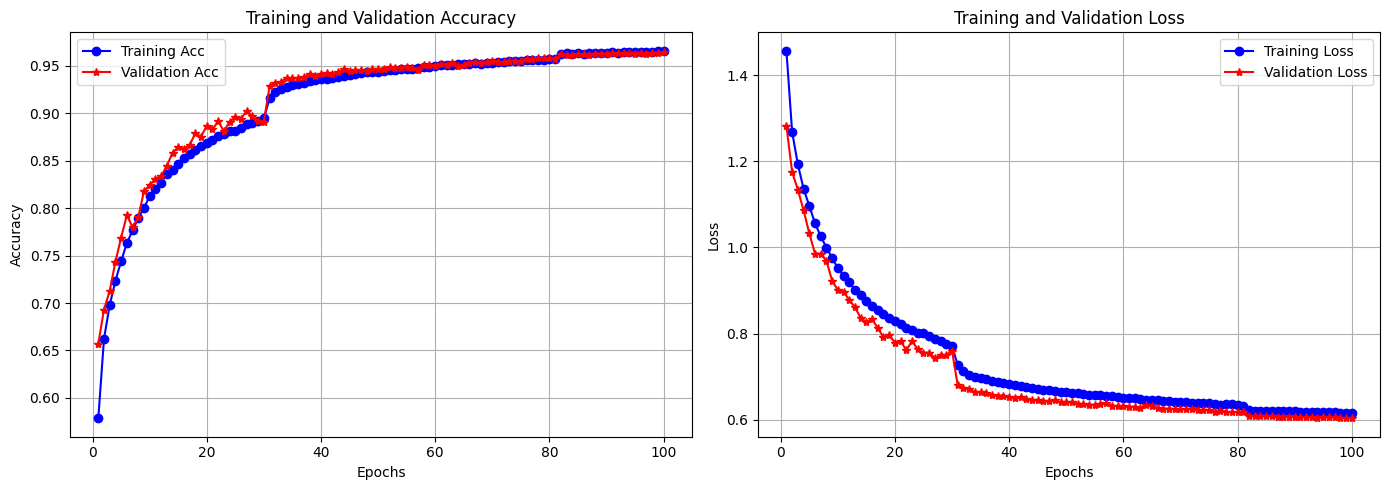

Generating predictions for Confusion Matrix...


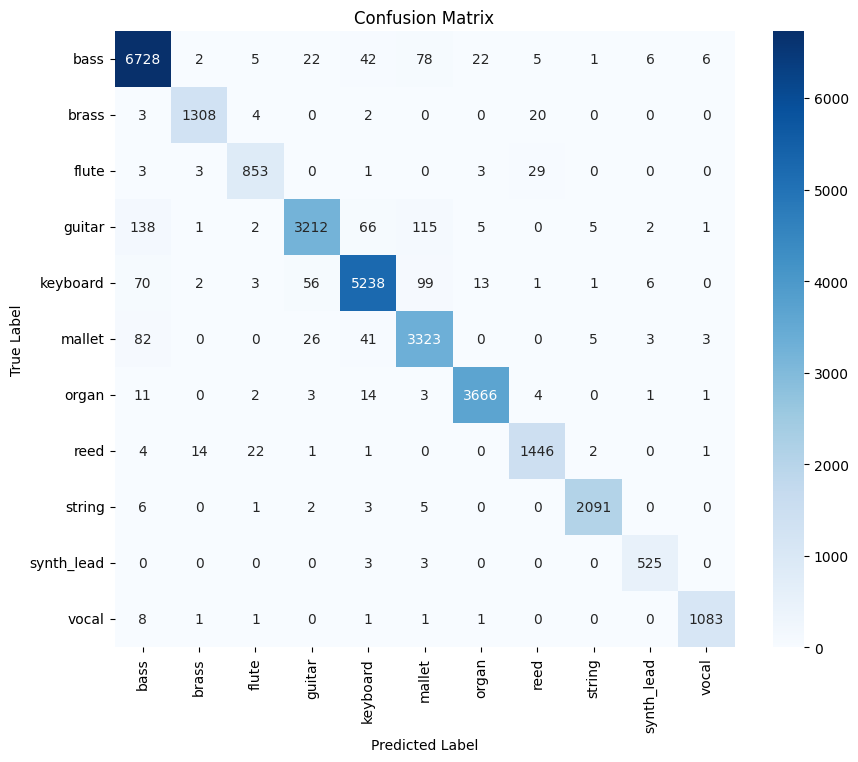

In [28]:
# Run the plotting function if training history exists
if 'history' in locals():
    plot_training_history(history)
else:
    print("⚠️ Variable 'history' not found. Please run the training cell first!")

# --- 2. Generate Confusion Matrix ---
print("Generating predictions for Confusion Matrix...")

# Get model predictions on the test set
y_pred_probs = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Get Class Names (e.g., 'Guitar', 'Piano') from the LabelEncoder
class_names = le.classes_

# Create the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()